## RFCDE Conditional Density Estimation Notebook
 
 In this notebook we demonstrate the training and evaluation of a conditional density estimator using the RFCDE random forest method.
 
 We first generate Brownian motion data, then define X as the value at time step 2 and Y as the value at time step 3.
 Finally, we train the RFCDE estimator and for a few chosen x values, we estimate the conditional density and sample from it.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
CD_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density"
)

if measure_sampling_path not in sys.path:
    sys.path.append(measure_sampling_path)

if CD_path not in sys.path:
    sys.path.append(CD_path)

from CD_RFCDE import *

from Gen_Path_and_AdaptedTrees import *
from scipy.stats import norm

In [2]:
# Generate Brownian motion paths
n_data = 3000
time_steps = 3  # For example, t=0, t=1, t=2
paths = generate_brownian_motion(num_paths=n_data, time_steps=time_steps, scale=1)

RFCDE training took 0.45 seconds.


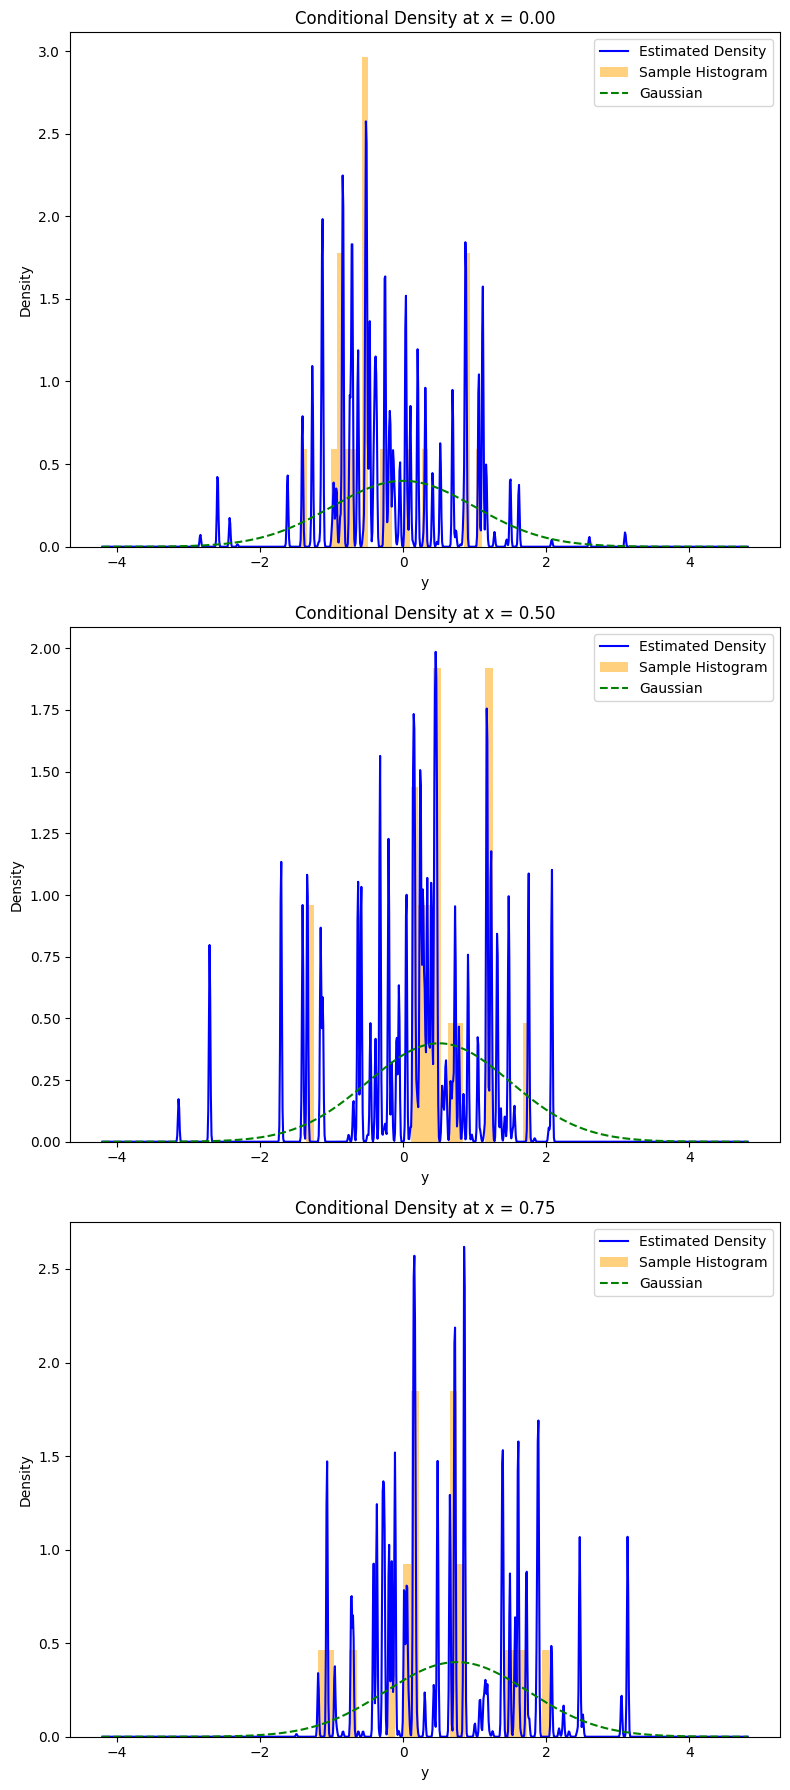

In [4]:
# For conditional density estimation, let X be the value at time step 2 and Y the value at time step 3.
X = paths[:, 1].reshape(-1, 1)
Y = paths[:, 2].reshape(-1, 1)

# Concatenate X and Y to form the dataset.
data = np.concatenate([X, Y], axis=1)

# %%
# Train the RFCDE conditional density estimator.
model_rfcde = train_conditional_density_rfcde(
    data,
    d_X=1,
    d_Y=1,
    n_trees=100,
    mtry=4,
    node_size=20,
    n_basis=30,
    basis_system="cosine",
)

# %%
# Evaluate the model at a few x values by sampling from the estimated density.
x_values = [0, 0.5, 0.75]
n_samples = 20  # Number of y samples to draw for each x.
samples_list = evaluate_conditional_density_rfcde(
    model_rfcde, x_values, n_samples=n_samples, n_grid=1000, bandwidth=0.01
)

fig, axs = plt.subplots(len(x_values), 1, figsize=(8, 6 * len(x_values)))
if not isinstance(axs, np.ndarray):
    axs = [axs]

for i, x0 in enumerate(x_values):
    # Create a grid for density estimation.
    z_min, z_max = model_rfcde.z_range
    z_grid = np.linspace(z_min, z_max, 1000)
    cde = model_rfcde.predict(np.array([x0], dtype=np.float64), z_grid, bandwidth=0.01)[
        0
    ]

    # Normalize the density.
    density = cde / np.trapz(cde, z_grid)

    # Plot estimated density
    axs[i].plot(z_grid, density, "b-", label="Estimated Density")

    # Plot histogram of sampled y values
    axs[i].hist(
        samples_list[i],
        bins=30,
        density=True,
        alpha=0.5,
        color="orange",
        label="Sample Histogram",
    )

    # Plot Gaussian distribution centered at x0 with variance=1
    gaussian = norm.pdf(z_grid, loc=x0, scale=1)
    axs[i].plot(z_grid, gaussian, "g--", label="Gaussian".format(x0))

    axs[i].set_title(f"Conditional Density at x = {x0:.2f}")
    axs[i].set_xlabel("y")
    axs[i].set_ylabel("Density")
    axs[i].legend()

plt.tight_layout()
plt.show()